In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import random
import copy
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from collections import deque
from scipy.optimize import curve_fit



# SAW class definition

In [2]:
# SAW of 2 dimensions
class saw2d():
  def __init__(self):
    self.walked_path = np.array([[0, 0]])
    self.curr_pos = np.array([0, 0])
    self.possible_moves = np.array([[1,  0],
                                    [-1, 0],
                                    [0,  1],
                                    [0, -1]])  # left right up down
    self.possible_trasforms = [
            # np.array([[1, 0], [0, 1]]),   # Identity
            np.array([[0, 1], [-1, 0]]),  # 90 degrees
            np.array([[0, -1], [1, 0]]),  # -90 degrees (270 degrees)
            np.array([[-1, 0], [0, -1]]), # 180 degrees
            np.array([[-1, 0], [0, 1]]),  # Reflection over y-axis
            np.array([[1, 0], [0, -1]]),  # Reflection over x-axis
            np.array([[0, 1], [1, 0]]),   # Reflection over y=x
            np.array([[0, -1], [-1, 0]]), # Reflection over y=-x
        ]


  def step(self):
    # get array of valid end-locations for next move
    next_moves = self.curr_pos + self.possible_moves

    # the below is incorrect because it generates wrong distribution
    # valid_idx = (~np.all(next_moves[:, None] == self.walked_path, axis=2)).all(axis=1)  # in-line optimization by gpt4
    # next_moves = next_moves[valid_idx]

    # print(f"next_moves: {next_moves}")
    # print(f"valid_idx: {valid_idx}")

    # if len(next_moves) == 0:
    #   # there are no valid moves
    #   # print("dead end reached")
    #   return False

    # there is a valid move
    # self.curr_pos = next_moves[np.random.choice(len(next_moves))]
    next_pos = next_moves[np.random.choice(len(next_moves))]
    if np.any(np.all(self.walked_path == next_pos, axis=1)):
      return False
    self.curr_pos = next_pos
    self.walked_path = np.vstack([self.walked_path, self.curr_pos])
    # print(f"walked to {self.curr_pos}")
    return True

  def take_steps(self, N):
    for n in range(N):
      if not self.step():
        return False
    return True

  def initial_walk(self, length):
    # generate straight line walk for initial step
    self.walked_path = np.array([[i, 0] for i in range(length+1)])
    self.curr_pos = self.walked_path[-1]
    return

  def plot_walk(self, min_range=-10, max_range=10):
    N = len(self.walked_path)
    x = self.walked_path[:, 0]
    y = self.walked_path[:, 1]
    plt.plot(x, y, marker='',linewidth=3)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

    ax_rangex = np.arange(min(min_range, min(x)), max(max_range, max(x)), step=1)
    ax_rangey = np.arange(min(min_range, min(y)), max(max_range, max(y)), step=1)

    plt.gca().set_xticks(ax_rangex)
    plt.gca().set_yticks(ax_rangey)
    plt.show()

  def set_curr_walk(self, new_path):
    self.walked_path = new_path
    self.current_pos = self.walked_path[-1]

  def get_omega2(self):
    # gets current squared end-to-end distance
    start = self.walked_path[0]
    end = self.walked_path[-1]
    omega2 = np.sum((end - start) ** 2)
    return omega2

  def get_S2(self):
    # gets current squared radius of gyration
    # root mean square distance of the object's parts from its center of mass
    N = len(self.walked_path) - 1  # N is the number of edges, which is path length minus one
    path_squared = np.sum(self.walked_path ** 2, axis=1)
    total_squared_sum = np.sum(path_squared)
    total_sum = np.sum(self.walked_path, axis=0)
    squared_total_sum = np.sum(total_sum ** 2)

    S_squared = (1 / (N + 1)) * total_squared_sum - (1 / (N + 1) ** 2) * squared_total_sum
    return S_squared

  def pivot(self):
    # Perform a pivot on the walk and return a new saw2d object
    if len(self.walked_path) < 3:
      print("error: path length < 3")
      return False # Can't pivot if there are fewer than 3 points

    pivot_index = random.randint(1, len(self.walked_path) - 1)
    pivot_point = self.walked_path[pivot_index]
    transformation = random.choice(self.possible_trasforms)
    # print(f"pivot point: {pivot_point}")
    # print(f"pivot operation: {transformation}")

    # Transform around the pivot point
    new_path = self.walked_path[:pivot_index + 1].copy()
    for point in self.walked_path[pivot_index + 1:]:
      vector = point - pivot_point
      rotated_vector = transformation.dot(vector)
      new_point = rotated_vector + pivot_point
      new_path = np.vstack((new_path, new_point))

    # Check new path
    if self.is_valid_walk(new_path):
      # print("pivot success")
      self.walked_path = new_path
      self.current_pos = self.walked_path[-1]
      return True
    else:
      # print("pivot failed")
      return False

  def is_valid_walk(self, path):
    # check if pivoted walk is saw
    return len(path) == len(set(tuple(p) for p in path))




# Generate samples naively (static)

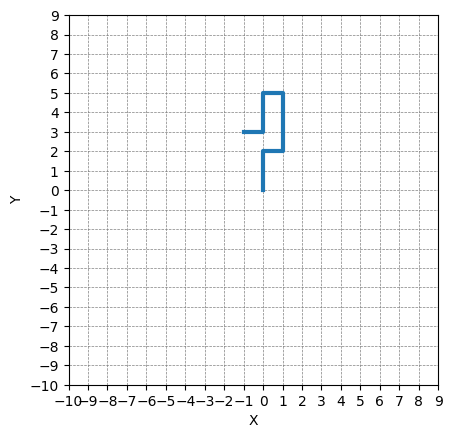

In [90]:
N = 10

saw = saw2d()

# saw.take_steps(N)
res = saw.take_steps(N)
while not res:
    saw = saw2d()
    res = saw.take_steps(N)

saw.plot_walk()
# saw.get_S2()

In [ ]:
N = 100
iters = 1000
omega2_arr = np.zeros(iters)
S2_arr = np.zeros(iters)


for i in range(iters):
  gen_success = False
  while not gen_success:
    saw = saw2d()
    gen_success = saw.take_steps(N)
  omega2_arr[i] = saw.get_omega2()
  S2_arr[i] = saw.get_S2()
  # saw.plot_walk()

# saw.plot_walk()
print(np.mean(omega2_arr))
print(np.mean(S2_arr))

# Generate samples with pivot algorithm (dynamic)

In [3]:
def generate_samples(n_samples=100, N=100, use_pivot=True, buffer_size=100, init="rod"):
  saw_list = deque(maxlen=buffer_size)  
  omega2_list = []
  s2_list = []

  if init == "rod":
    saw_initial = saw2d()
    saw_initial.initial_walk(length=N)
  elif init == "walk":
    saw_initial = saw2d()
    res = saw_initial.take_steps(N)
    while not res:
      saw_initial = saw2d()
      res = saw_initial.take_steps(N)

  saw_list.append(saw_initial.walked_path)
  print(' ', end='', flush=True)


  for i in trange(n_samples):
    # ind = -(int)(len(saw_list)/2)
    ind = random.randint((int)(len(saw_list)/2), len(saw_list)-1)
    # saw_pwalk_prev = random.choice(list(saw_list)[ind:])
    # saw_pwalk_prev = saw_list[-1]
    saw_pwalk_prev = saw_list[ind]
    saw_curr = saw2d()
    saw_curr.set_curr_walk(saw_pwalk_prev)


    success = saw_curr.pivot()
    # while not success:
    #   success = saw_curr.pivot()

    saw_list.append(saw_curr.walked_path)
    omega2_list.append(saw_curr.get_omega2())
    s2_list.append(saw_curr.get_S2())

    i += 1

  return saw_list, omega2_list, s2_list


In [96]:
n_samples = int(1e7)
num_discard = int(1e6)
buffer_size = int(n_samples / 10)

Ns = [15, 20]

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples(n_samples=n_samples, N=N, buffer_size=buffer_size, init="walk")
    print(f"omega^2: {np.mean(omega2_list)}")
    print(f"S^2: {np.mean(s2_list)}")
    print(f"omega^2: {np.mean(omega2_list[-num_discard:])}")
    print(f"S^2: {np.mean(s2_list[-num_discard:])}")

    return np.mean(omega2_list[num_discard:]), np.mean(s2_list[num_discard:])


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

# Unzip the results into omega2s and s2s
omega2s, s2s = zip(*results)

# Print the results
print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

  0%|          | 0/10000000 [00:00<?, ?it/s]

omega^2: 47.8579468
S^2: 6.9195418390625
omega^2: 47.455468
S^2: 6.8257233828125
omega^2: 72.2129072
S^2: 10.443391731065748
omega^2: 72.528234
S^2: 10.381445297052151
omega^2: (47.816578666666665, 72.32238688888889)
S^2: (6.904807703993056, 10.436332014109352)


For N= (15,20):

omega^2: (47.816578666666665, 72.32238688888889)

S^2: (6.904807703993056, 10.436332014109352)

## Estimating nu

In [8]:
np.array(range(0, 8000, 800))  

array([   0,  800, 1600, 2400, 3200, 4000, 4800, 5600, 6400, 7200])

In [9]:
# Ns = [20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1600, 2000, 3000, 4000, 5000, 6000, 8000]
Ns = np.array([   50, 100,  800, 1600, 2400, 3200, 4000, 4800, 5600, 7200])
# Ns = np.array(range(0, 8000, 400))  
n_samples = int(1e6)
num_discard = int(3*1e5)
buffer_size = int(n_samples / 10)

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples(n_samples=n_samples, N=N, buffer_size=buffer_size, init="rod")

    return np.mean(omega2_list[num_discard:]), np.mean(s2_list[num_discard:])


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

# Unzip the results into omega2s and s2s
omega2s, s2s = zip(*results)

# Print the results
print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [103]:
def fit_power_law(N_values, omega_squared_values):
    def power_law(N, A, p):
        return A * N ** p

    popt, pcov = curve_fit(power_law, N_values, omega_squared_values)
    return popt


Fitted parameters:
A = 0.08161869657997735
p = 2.060619180470234


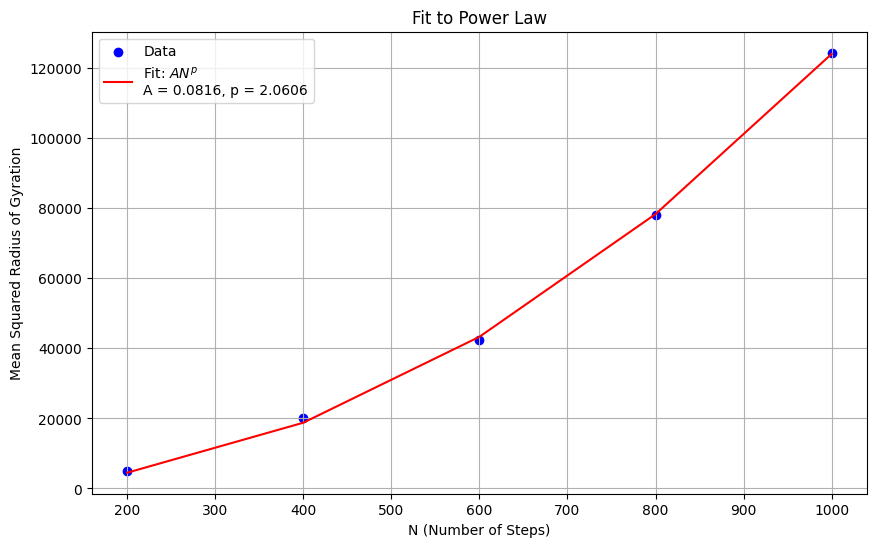

In [106]:
A, p = fit_power_law(Ns, omega2s)
print(f"Fitted parameters:\nA = {A}\np = {p}")

plt.figure(figsize=(10, 6))
plt.scatter(Ns, omega2s, color='blue', label='Data')
plt.plot(Ns, A * Ns ** p, color='red', label=f'Fit: $AN^p$\nA = {A:.4f}, p = {p:.4f}')
plt.xlabel('N (Number of Steps)')
plt.ylabel('Mean Squared Radius of Gyration')
plt.title('Fit to Power Law')
plt.legend()
plt.grid(True)
plt.show()


Fitted parameters:
A = 0.1328089055455785
p = 1.987513180985444


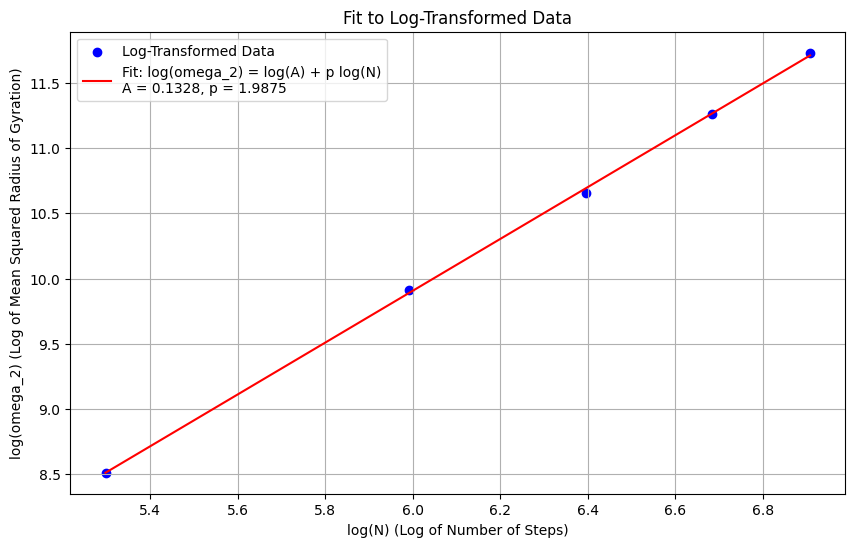

In [109]:
log_N = np.log(Ns)
log_mean_squared_radii = np.log(omega2s)

# Perform linear regression on the log-transformed data
coefficients = np.polyfit(log_N, log_mean_squared_radii, 1)
p = coefficients[0]
log_A = coefficients[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\np = {p}")



plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_mean_squared_radii, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(omega_2) = log(A) + p log(N)\nA = {A:.4f}, p = {p:.4f}')
plt.xlabel('log(N) (Log of Number of Steps)')
plt.ylabel('log(omega_2) (Log of Mean Squared Radius of Gyration)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()


# Higher dimensional saw


In [ ]:
# Generate the transformations for 3D - 48 elements in Octahedral symmetry group
# Generation code by gpt4
I = np.eye(3)

# 90-degree rotations
R_x_90 = np.array([[1, 0, 0],
                   [0, 0, -1],
                   [0, 1, 0]])
R_y_90 = np.array([[0, 0, 1],
                   [0, 1, 0],
                   [-1, 0, 0]])
R_z_90 = np.array([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

R_x_180 = np.linalg.matrix_power(R_x_90, 2)
R_y_180 = np.linalg.matrix_power(R_y_90, 2)
R_z_180 = np.linalg.matrix_power(R_z_90, 2)

R_x_270 = np.linalg.matrix_power(R_x_90, 3)
R_y_270 = np.linalg.matrix_power(R_y_90, 3)
R_z_270 = np.linalg.matrix_power(R_z_90, 3)

# Reflections
M_x = np.array([[-1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]])
M_y = np.array([[1, 0, 0],
                [0, -1, 0],
                [0, 0, 1]])
M_z = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, 0, -1]])

# Improper 90-degree rotations
R_x_90_prime = np.dot(M_x, R_x_90)
R_y_90_prime = np.dot(M_y, R_y_90)
R_z_90_prime = np.dot(M_z, R_z_90)

# Improper 180-degree rotations
R_x_180_prime = np.dot(M_x, R_x_180)
R_y_180_prime = np.dot(M_y, R_y_180)
R_z_180_prime = np.dot(M_z, R_z_180)

# Improper 270-degree rotations
R_x_270_prime = np.dot(M_x, R_x_270)
R_y_270_prime = np.dot(M_y, R_y_270)
R_z_270_prime = np.dot(M_z, R_z_270)

# Combine the matrices into the full group
matrices = [I,
            R_x_90, R_x_270, R_y_90, R_y_270, R_z_90, R_z_270,
            R_x_180, R_y_180, R_z_180,
            M_x, M_y, M_z,
            R_x_90_prime, R_y_90_prime, R_z_90_prime,
            R_x_180_prime, R_y_180_prime, R_z_180_prime,
            R_x_270_prime, R_y_270_prime, R_z_270_prime,
            ]

# Add all 48 unique matrices

# Generate all 24 different rotation matrices using normal rotations
# need to convert to hashable tuples
rotation_matrix_set = set(map(tuple, [tuple(map(tuple, rotate)) for rotate in [I, R_x_90, R_x_180, R_x_270, R_y_90, R_y_180, R_y_270, R_z_90, R_z_180, R_z_270]]))
while len(rotation_matrix_set) < 24:
    new_rotations = []
    for R1 in rotation_matrix_set:
        for R2 in [I, R_x_90, R_x_180, R_x_270, R_y_90, R_y_180, R_y_270, R_z_90, R_z_180, R_z_270]:
            new_rotation = np.dot(np.array(R1), R2)
            if tuple(map(tuple, new_rotation)) not in rotation_matrix_set:
                new_rotations.append(new_rotation)
    rotation_matrix_set.update(map(tuple, [tuple(map(tuple, rotate)) for rotate in new_rotations]))

# Generate all 24 different improper rotation matrices using reflections and rotations
improper_rotation_matrix_set = set()

for reflection in [M_x, M_y, M_z]:
    for rotation in rotation_matrix_set:
        improper_rotation = np.dot(reflection, np.array(rotation))
        improper_rotation_matrix_set.add(tuple(map(tuple, improper_rotation)))

# Combine rotations and improper rotations
transformations_group = list(rotation_matrix_set) + list(improper_rotation_matrix_set)
transformations_mat_group = [np.array(tup) for tup in transformations_group]
print(f'Total number of matrices: {len(transformations_mat_group)}')

# Print all the matrices
for matrix in transformations_mat_group:
    print(matrix)
    print()


Total number of matrices: 48
[[ 0  0  1]
 [-1  0  0]
 [ 0 -1  0]]

[[-1  0  0]
 [ 0  0  1]
 [ 0  1  0]]

[[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]]

[[0 1 0]
 [0 0 1]
 [1 0 0]]

[[-1  0  0]
 [ 0  0 -1]
 [ 0 -1  0]]

[[ 1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]

[[ 0  0  1]
 [ 0  1  0]
 [-1  0  0]]

[[ 0  0 -1]
 [ 1  0  0]
 [ 0 -1  0]]

[[ 0  1  0]
 [ 0  0 -1]
 [-1  0  0]]

[[ 1  0  0]
 [ 0  0 -1]
 [ 0  1  0]]

[[ 0 -1  0]
 [ 0  0  1]
 [-1  0  0]]

[[ 0  0 -1]
 [-1  0  0]
 [ 0  1  0]]

[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]

[[ 0  0  1]
 [ 0 -1  0]
 [ 1  0  0]]

[[ 0 -1  0]
 [-1  0  0]
 [ 0  0 -1]]

[[ 0 -1  0]
 [ 0  0 -1]
 [ 1  0  0]]

[[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]]

[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]

[[ 0  0 -1]
 [ 0 -1  0]
 [-1  0  0]]

[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]

[[ 0  0 -1]
 [ 0  1  0]
 [ 1  0  0]]

[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[[0 0 1]
 [1 0 0]
 [0 1 0]]

[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]

[[-1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]

[

In [ ]:
# SAW of 3 dimensions
class saw3d():
  def __init__(self):
    self.walked_path = np.array([[0, 0, 0]])
    self.curr_pos = np.array([0, 0, 0])
    self.possible_moves = np.array([[1,  0, 0],
                                    [-1, 0, 0],
                                    [0,  0, 1],
                                    [0, 0, -1],
                                    [0,  1, 0],
                                    [0, -1, 0]])
    self.possible_trasforms = transformations_mat_group

  def step(self):
    # get array of valid end-locations for next move
    next_moves = self.curr_pos + self.possible_moves
    valid_idx = (~np.all(next_moves[:, None] == self.walked_path, axis=2)).all(axis=1)  # in-line optimization by gpt4
    next_moves = next_moves[valid_idx]
    # print(f"next_moves: {next_moves}")
    # print(f"valid_idx: {valid_idx}")

    if len(next_moves) == 0:
      # there are no valid moves
      # print("dead end reached")
      return False

    # there is a valid move
    self.curr_pos = next_moves[np.random.choice(len(next_moves))]
    self.walked_path = np.vstack([self.walked_path, self.curr_pos])
    # print(f"walked to {self.curr_pos}")
    return True

  def take_steps(self, N):
    for n in range(N):
      if not self.step():
        return False
    return True

  def plot_walk(self, min_range=-10, max_range=10):
    N = len(self.walked_path)
    x = self.walked_path[:, 0]
    y = self.walked_path[:, 1]
    z = self.walked_path[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the path
    ax.plot(x, y, z, marker='', linestyle='-', linewidth=2)

    # plt.plot(x, y, z, marker='',linewidth=3)
    # plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    # ax.set_aspect('equal', adjustable='box')
    ax.set_box_aspect(aspect=(1, 1, 1))


    ax_rangex = np.arange(min(min_range, min(x)), max(max_range, max(x)), step=1)
    ax_rangey = np.arange(min(min_range, min(y)), max(max_range, max(y)), step=1)
    ax_rangez = np.arange(min(min_range, min(z)), max(max_range, max(z)), step=1)

    ax.set_xticks(ax_rangex)
    ax.set_yticks(ax_rangey)
    ax.set_zticks(ax_rangez)
    plt.show()

  def get_omega2(self):
    # gets current squared end-to-end distance
    start = self.walked_path[0]
    end = self.walked_path[-1]
    omega2 = np.sum((end - start) ** 2)
    return omega2

  def get_S2(self):
    # gets current squared radius of gyration
    # root mean square distance of the object's parts from its center of mass
    N = len(self.walked_path) - 1  # N is the number of edges, which is path length minus one
    path_squared = np.sum(self.walked_path ** 2, axis=1)
    total_squared_sum = np.sum(path_squared)
    total_sum = np.sum(self.walked_path, axis=0)
    squared_total_sum = np.sum(total_sum ** 2)

    S_squared = (1 / (N + 1)) * total_squared_sum - (1 / (N + 1) ** 2) * squared_total_sum
    return S_squared

  def pivot(self):
    # Perform a pivot on the walk and return a new saw2d object
    if len(self.walked_path) < 3:
      print("error: path length < 3")
      return False # Can't pivot if there are fewer than 3 points

    pivot_index = random.randint(1, len(self.walked_path) - 2)
    pivot_point = self.walked_path[pivot_index]
    transformation = random.choice(self.possible_trasforms)
    print(f"pivot point: {pivot_point}")
    print(f"pivot operation: {transformation}")

    # Transform around the pivot point
    new_path = self.walked_path[:pivot_index + 1].copy()
    for point in self.walked_path[pivot_index + 1:]:
      vector = point - pivot_point
      rotated_vector = transformation.dot(vector)
      new_point = rotated_vector + pivot_point
      new_path = np.vstack((new_path, new_point))

    # Check new path
    if self.is_valid_walk(new_path):
      print("pivot success")
      self.walked_path = new_path
      self.current_pos = self.walked_path[-1]
      return True
    else:
      print("pivot failed")
      return False

  def is_valid_walk(self, path):
    # check if pivoted walk is saw
    return len(path) == len(set(tuple(p) for p in path))




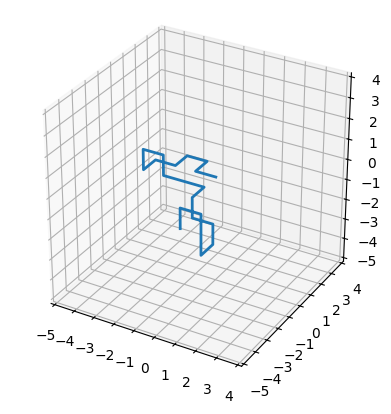

In [ ]:
N = 20
saw = saw3d()
saw.take_steps(N)
saw.plot_walk(-5,5)


In [ ]:
def generate_samples_3d(n_samples=100, N=100, use_pivot=True):
  saw_list = []
  omega2_list = []

  gen_success = False

  while not gen_success:
    saw_initial = saw3d()
    gen_success = saw_initial.take_steps(N)
    if gen_success:
      saw_list.append(saw_initial)

  # for _ in range(n_samples):
  i = 0
  while i < n_samples:
    # saw_prev = saw_list[-1] TODO:
    saw_prev = random.choice(saw_list)
    saw_curr = copy.deepcopy(saw_prev)

    success = saw_curr.pivot()
    if success:
      saw_list.append(saw_curr)
      omega2_list.append(saw_curr.get_omega2())
      i += 1

  return saw_list, omega2_list


pivot point: [-10  -5  -7]
pivot operation: [[ 0  0 -1]
 [ 1  0  0]
 [ 0 -1  0]]
pivot failed
pivot point: [-3 -2  3]
pivot operation: [[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
pivot failed
pivot point: [-2 -4  2]
pivot operation: [[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
pivot success
pivot point: [-1 -1  1]
pivot operation: [[ 0  0  1]
 [ 0  1  0]
 [-1  0  0]]
pivot failed
pivot point: [-10  -5  -9]
pivot operation: [[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
pivot failed
pivot point: [ 3 -5  9]
pivot operation: [[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]
pivot success
pivot point: [ 1 -7  8]
pivot operation: [[-1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]
pivot failed
pivot point: [ 4 -4  7]
pivot operation: [[-1  0  0]
 [ 0  0 -1]
 [ 0 -1  0]]
pivot failed
pivot point: [-2 -4  2]
pivot operation: [[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]]
pivot failed
pivot point: [-2 -5 11]
pivot operation: [[ 0 -1  0]
 [ 0  0  1]
 [-1  0  0]]
pivot success
pivot point: [-6 -5 16]
pivot operation: [[ 1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]
piv

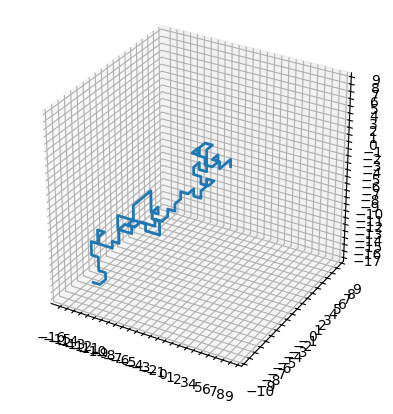

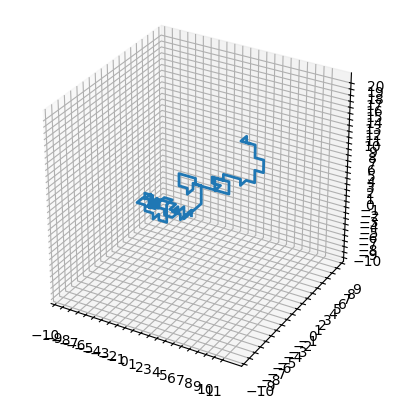

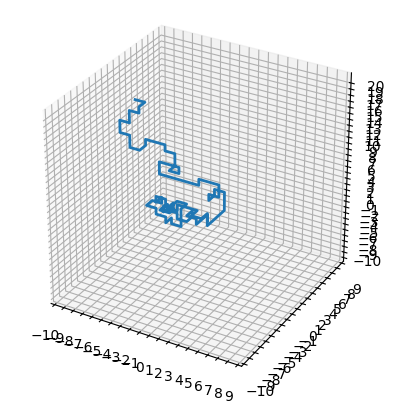

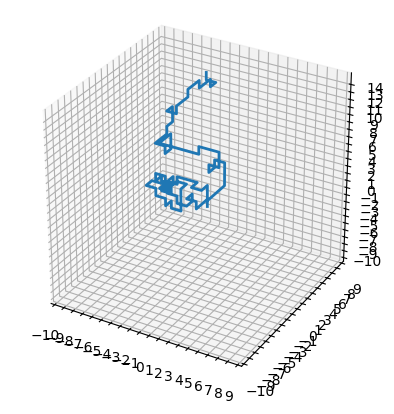

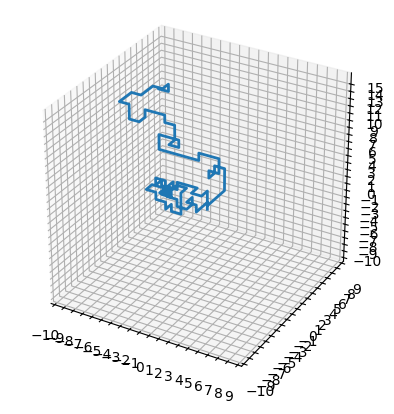

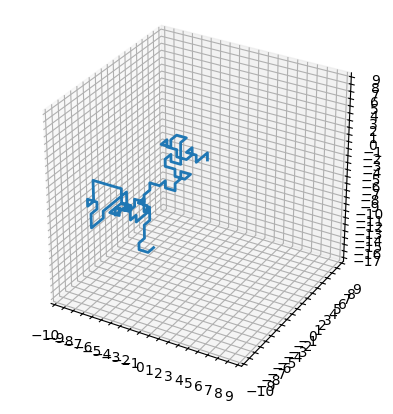

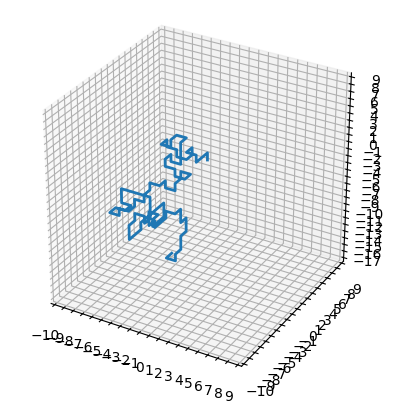

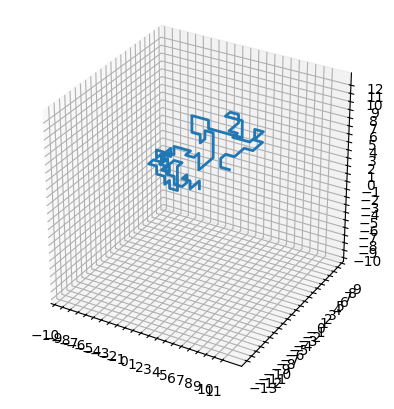

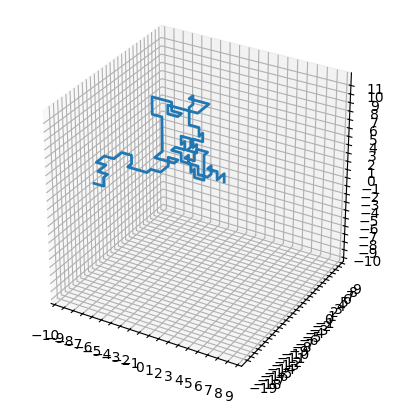

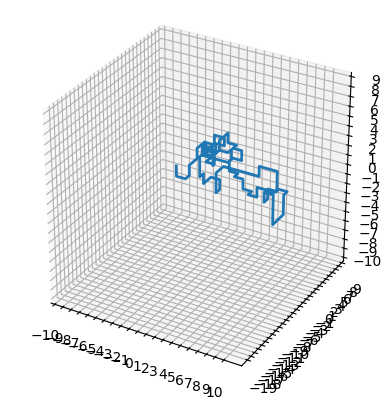

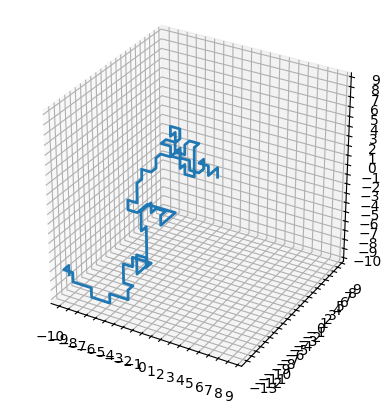

In [ ]:
N = 20

saw_list, omega2_list = generate_samples_3d(n_samples=10, N=100)

for s in saw_list:
  s.plot_walk(-10,10)


# Implementation improvements on pivot algo
